In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

In [2]:
# 1. Load and preprocess the dataset
def load_mnist_data():
    mnist = fetch_openml('mnist_784', version=1)  # Fetch MNIST dataset from OpenML
    data = mnist['data'].values  # Image pixel values
    target = mnist['target'].astype(int).values  # Labels (0-9 for digits)
    return data, target

# Load dataset
data, target = load_mnist_data()

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Normalize the pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape the data to 28x28 pixels for each image (MNIST is 28x28 grayscale images)
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# 2. Add Gaussian noise to the images
def add_gaussian_noise(image, noise_factor=0.5):
    noisy_image = image + noise_factor * np.random.randn(*image.shape)  # Add Gaussian noise
    noisy_image = np.clip(noisy_image, 0., 1.)  # Clip the values to [0, 1] range
    return noisy_image

In [4]:
# 3. Noise reduction using Gaussian blur
def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur to reduce noise

In [5]:
# 4. Training with noisy images
# Add noise to training and testing images
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test])

# Apply Gaussian blur to denoise the images
X_train_cleaned = np.array([gaussian_blur(img) for img in X_train_noisy])
X_test_cleaned = np.array([gaussian_blur(img) for img in X_test_noisy])

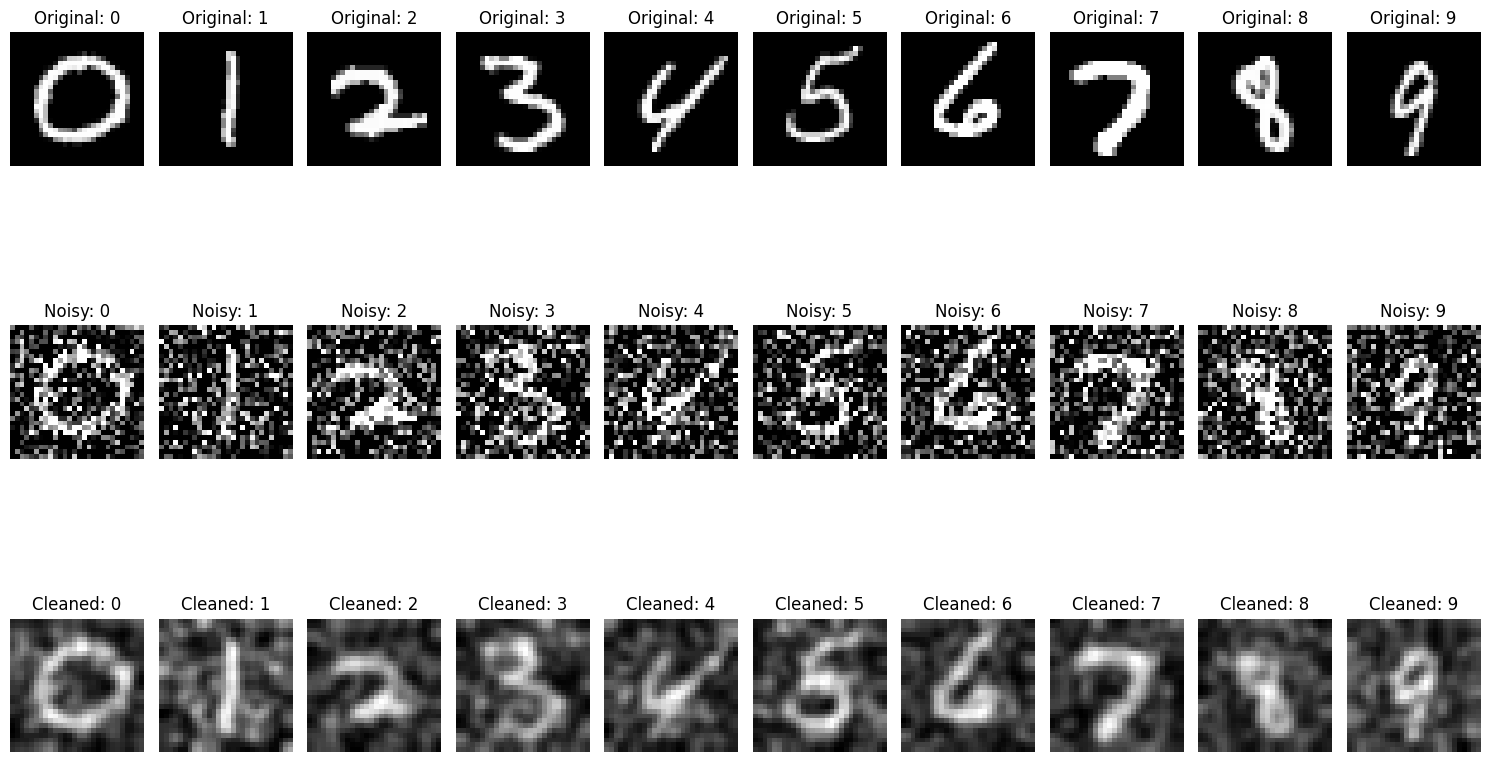

In [6]:
# 5. Visualize the images: original, noisy, and cleaned
def visualize_images(original, noisy, cleaned, labels, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Find the index of the first occurrence of each digit 0-9
        digit_index = np.where(labels == i)[0][0]

        # Original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(original[digit_index], cmap='gray')
        plt.title(f"Original: {i}")
        plt.axis('off')

        # Noisy image
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy[digit_index], cmap='gray')
        plt.title(f"Noisy: {i}")
        plt.axis('off')

        # Cleaned image
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(cleaned[digit_index], cmap='gray')
        plt.title(f"Cleaned: {i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images for digits 0-9
visualize_images(X_train, X_train_noisy, X_train_cleaned, y_train, num_images=10)

In [11]:
# 6. Define the model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the input image
        tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with ReLU activation
        tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer with softmax for classification (10 classes)
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# 7. Train the model
# Train with noisy images
model_noisy = create_model()
model_noisy.fit(X_train_noisy, y_train, epochs=3, validation_data=(X_test_noisy, y_test))

# Train with cleaned images
model_cleaned = create_model()
model_cleaned.fit(X_train_cleaned, y_train, epochs=3, validation_data=(X_test_cleaned, y_test))

Epoch 1/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6956 - loss: 0.9371 - val_accuracy: 0.8596 - val_loss: 0.4447
Epoch 2/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8632 - loss: 0.4338 - val_accuracy: 0.8819 - val_loss: 0.3750
Epoch 3/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8920 - loss: 0.3367 - val_accuracy: 0.8933 - val_loss: 0.3401
Epoch 1/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7030 - loss: 0.9519 - val_accuracy: 0.8501 - val_loss: 0.4740
Epoch 2/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8354 - loss: 0.5129 - val_accuracy: 0.8769 - val_loss: 0.3973
Epoch 3/3
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8585 - loss: 0.4420 - val_accuracy: 0.8944 - val_loss: 0.3413


In [13]:
# 8. Evaluate the model performance
test_loss_noisy, test_acc_noisy = model_noisy.evaluate(X_test_noisy, y_test)
test_loss_cleaned, test_acc_cleaned = model_cleaned.evaluate(X_test_cleaned, y_test)

print(f"Test Accuracy with Noisy Images: {test_acc_noisy * 100:.2f}%")
print(f"Test Accuracy with Cleaned Images: {test_acc_cleaned * 100:.2f}%")

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8917 - loss: 0.3377
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.3392
Test Accuracy with Noisy Images: 89.33%
Test Accuracy with Cleaned Images: 89.44%


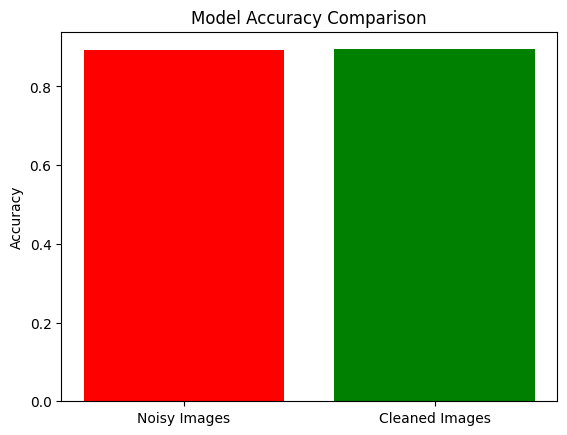

In [14]:
# 9. Visualize the results
accuracies = [test_acc_noisy, test_acc_cleaned]
labels = ['Noisy Images', 'Cleaned Images']

plt.bar(labels, accuracies, color=['red', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()